# Kalman Filter und Sensor Fusion

siehe auch:
- https://www.kalmanfilter.net/default.aspx

In [2]:
import numpy as np
import matplotlib.pylab as plt

## Beispiel für die Funktionsweise eines Kalman Filters

Um das Grundkonzept von Kalman Filtern zu verstehen werden wir hier in einem unrealistischen Beispiel zeigen, wie die `prediction` und `update` Schritte funktionieren und Mittelwerte sowie Unsicherheiten mit neuen Werten aktualisiert werden.

siehe auch:
- https://medium.com/analytics-vidhya/kalman-filters-a-step-by-step-implementation-guide-in-python-91e7e123b968
- https://github.com/Garima13a/Kalman-Filters

Below is our usual Gaussian equation and imports.

In [334]:
# gaussian function
f = lambda mu, sigma2, x: (1.0 / np.sqrt(2.0 * np.pi * sigma2)) * np.exp(-0.5 * (x-mu) ** 2 / sigma2)

You've also been given the complete `update` code that performs a parameter update when an initial belief and new measurement information are merged. And the complete `predict` code that performs an update to a Gasuuain after a motion is incorporated.

In [335]:
# the update function
def update(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters.'''
    # Calculate the new parameters
    new_mean = (var2*mean1 + var1*mean2)/(var2+var1)
    new_var = 1/(1/var2 + 1/var1)
    
    return [new_mean, new_var]


# the motion update/predict function
def predict(mean1, var1, mean2, var2):
    ''' This function takes in two means and two squared variance terms,
        and returns updated gaussian parameters, after motion.'''
    # Calculate the new parameters
    new_mean = mean1 + mean2
    new_var = var1 + var2
    
    return [new_mean, new_var]

In [336]:
update(20,9,30,3)

[27.5, 2.25]

### Initial Uncertainty

You'll see that you are given initial parameters below, and this includes and initial location estimation, $\mu$ and squared variance, $\sigma$. Note that the initial estimate is set to the location 0, and the variance is extremely large; this is a state of high confusion much like the *uniform* distribution we used in the histogram filter. There are also values given for the squared variance associated with the sensor measurements and the motion, since neither of those readings are perfect, either.

You should see that even though the initial estimate for location (the initial $\mu$) is far from the first measurement, it should catch up fairly quickly as you cycle through measurements and motions.

In [337]:
# measurements for mu and motions, U
measurements = [5., 6., 7., 9., 10.]
motions = [1., 1., 2., 1., 1.]

# initial parameters
measurement_sig = 4.
motion_sig = 2.
mu = 0.
sig = 10000.


## TODO: Loop through all measurements/motions
# this code assumes measurements and motions have the same length
# so their updates can be performed in pairs
data = np.zeros((len(measurements), 2))
for n in range(len(measurements)):
    # measurement update, with uncertainty
    mu, sig = update(mu, sig, measurements[n], measurement_sig)
    print('Update: [{}, {}]'.format(mu, sig))
    data[n,:] = (mu, sig)
    # motion update, with uncertainty
    mu, sig = predict(mu, sig, motions[n], motion_sig)
    print('Predict: [{}, {}]'.format(mu, sig))

    
# print the final, resultant mu, sig
print('\n')
print('Final result: [{}, {}]'.format(mu, sig))

Update: [4.998000799680128, 3.9984006397441023]
Predict: [5.998000799680128, 5.998400639744102]
Update: [5.999200191953932, 2.399744061425258]
Predict: [6.999200191953932, 4.399744061425258]
Update: [6.999619127420922, 2.0951800575117594]
Predict: [8.999619127420921, 4.09518005751176]
Update: [8.999811802788143, 2.0235152416216957]
Predict: [9.999811802788143, 4.023515241621696]
Update: [9.999906177177365, 2.0058615808441944]
Predict: [10.999906177177365, 4.005861580844194]


Final result: [10.999906177177365, 4.005861580844194]


In [342]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.errorbar(t[0:len(measurements)], data[:,0], yerr=1.*data[:,1])
plt.plot(measurements, "o")
plt.errorbar(range(len(measurements)), data[:,0], yerr=1.*data[:,1])
plt.fill_between(range(len(measurements)), (data[:,0] - data[:,1]), (data[:,0] + data[:,1]), alpha=0.2, label='error band')
plt.grid()

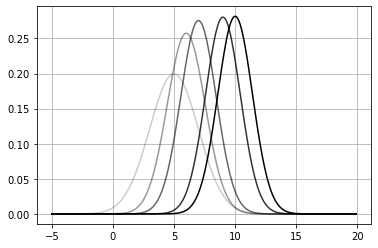

In [340]:
# may be create an animation (a bit like QM plots...)
#   -> https://towardsdatascience.com/matplotlib-animations-in-jupyter-notebook-4422e4f0e389?gi=ec8bc3e1f71f

# define a range of x values
x_axis = np.arange(-5, 20, 0.1)

# create a corresponding list of gaussian funcs
for n in range(len(measurements)):
    g = f(data[n,0], data[n,1], x_axis)

    # plot the result 
    plt.plot(x_axis, g, "k", alpha=(n+1)*0.2)

plt.grid()

Dieser Ablauf der Gauss-Kurven (von hell zu dunkler) zeigt wie sich der "state" über die Zeit weiterentwickelt, für ein anderes animiertes Beispiel, siehe: 
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

## Realistisches Beispiel für einen Kalman Filter

Für eine Rakete soll ein Höhenmesser implementiert werden.

Wir generieren/simulieren Daten für einen solchen Flug. Die Daten werden erzeugt durch einfache Euler-Integration ausgehend von vorgegeben Beschleunigungsdaten. Zu diese "exakten" Daten wird dann Rauschen addiert um Messwerte zu erzeugen.

In [347]:
# rocket flight test data including noise

dt = 0.1
noise_s = 10
noise_a = 1

t = np.arange(0, 20, dt)

n = t.shape
k = n[0]//4

a = np.zeros(n)
v = np.zeros(n)
s = np.zeros(n)

a[:(1*k)]      =  0.    #  0...5s:  5s auf Rampe
a[(1*k):(2*k)] = 10.    #  5..10s:  5s Brenndauer; Beschleunigung 10m/s^2
a[(2*k):]      = -9.81  # 10..20s: 10s Ballistische Bahn; Beschleunigung -g

dv = a[1:] * dt
v[1:] = np.cumsum(dv)

ds = v[1:] * dt
s[1:] = np.cumsum(ds)

sn = noise_s * (np.random.random(s.shape)*2-1)
an = noise_a * (np.random.random(a.shape)*2-1)

s_meas = s + sn
a_meas = a + an

In [348]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.figure(dpi=150)

plt.scatter(t, s_meas)
plt.plot(t, s)

plt.grid()

plt.show()

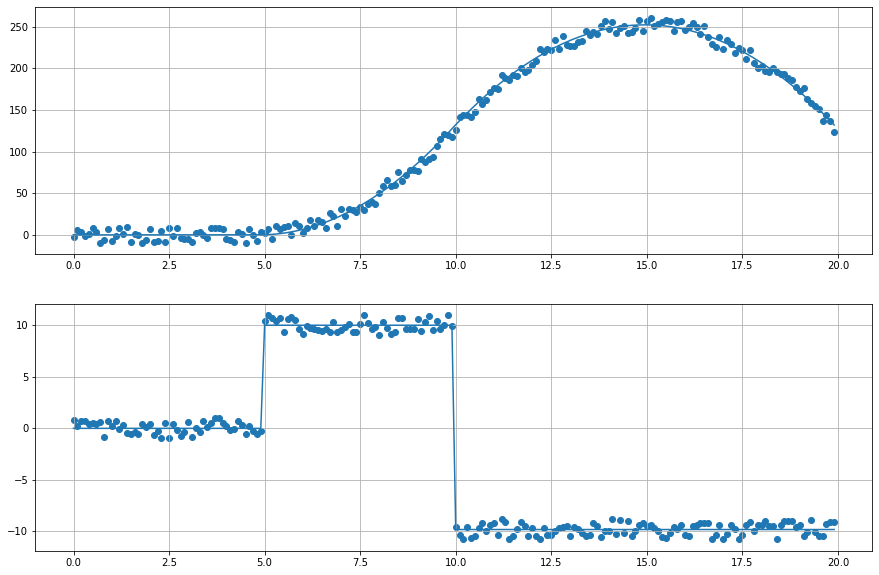

In [349]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.figure(dpi=150)

plt.subplot(211)

plt.scatter(t, s_meas)
plt.plot(t, s)

plt.grid()


plt.subplot(212)

plt.scatter(t, a_meas)
plt.plot(t, a)
#plt.scatter(t, v)
#plt.plot(t, v)

plt.grid()

plt.show()

## Kalman Filter mit 1 Sensor (Barometer)

Um die Parameter und Begriffe im Zusammenhang mit Kalman Filtern zu verstehen werden wir hier in einem realistischen Beispiel zeigen, welche Werte diese Grössen annehmen. 

Dafür verwenden wir das Paket `pykalman` welches "dead-simple" Kalman Filter implementiert die sich dadurch auszeichnen, dass sie nicht bekannte Parameter schätzen bzw. aus vorhandenen Daten lernen können. Danach können wir das Resultat sowie die Parameter studieren. Der Filter ist durch diese Parameter vollständig bestimmt.

siehe auch:
- https://pykalman.github.io/
- https://en.wikipedia.org/wiki/Kalman_filter

In [328]:
from pykalman import KalmanFilter  # pip install pykalman

Als "observables" also von Sensoren gemessene Werte verwenden wir hier nur den Ort (Höhe). Als "states" also interne Variablen die den Zustand des Systems beschreiben verwenden wir den Ort (s), die Geschwindigkeit (v) und die Beschleunigung (a). Wir erhalten diese Grössen hier somit gratis mit dazu und können uns eine Integration (Euler, Runge-Kutta, etc.) ersparen.

Die Matrix $A$ ist die sogenannte "transition matrix" die beschreibt wie aus den letzten states (s, v, a) die neuen berechnet (integriert) werden, das ist das (physikalische) Modell. Berechnet werden die Einträge von A wie folgt:

$
s = s_0 + v_0 \cdot t + 1/2 \cdot a \cdot t^2 \\
v = v_0 + a \cdot t \\
a = a \\
$

$
A =
\left[ {\begin{array}{ccc}
  \frac{\partial s}{\partial s_0} & \frac{\partial s}{\partial v_0} & \frac{\partial s}{\partial a} \\
  \frac{\partial v}{\partial s_0} & \frac{\partial v}{\partial v_0} & \frac{\partial v}{\partial a} \\
  \frac{\partial a}{\partial s_0} & \frac{\partial a}{\partial v_0} & \frac{\partial a}{\partial a} \\
\end{array} } \right]
$

Wir trauen dem Modell sehr stark - tendenziell mehr als den Messdaten - darum setzen wir für die "transition_covariance" sehr tiefe Werte: $I_{3x3} \cdot 0.01$
Die "transition_covariance" wird vom Erwartungs-Maximierungs-Algorithmus (EM) lokal optimiert, darum muss ein nahe liegender Anfangswert vorgegeben werden.

In [543]:
A = np.array([[1, dt, 0.5 * (dt**2)],
              [0,  1,            dt],
              [0,  0,             1]])

kf = KalmanFilter(transition_matrices = A, transition_covariance=0.01*np.eye(3), n_dim_state=3, n_dim_obs=1)
measurements = np.asarray([s_meas]).T  # 1 observation(s)
kf = kf.em(measurements)
#kf = kf.em(measurements[0:10])
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
#(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

test1 = filtered_state_means[:,0]

plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.plot(t, filtered_state_means[:,0])
plt.errorbar(t, filtered_state_means[:,0], yerr=np.sqrt(filtered_state_covariances[:,0,0]))
#plt.fill_between(t, (filtered_state_means[:,0] - np.sqrt(filtered_state_covariances[:,0,0])), (filtered_state_means[:,0] + np.sqrt(filtered_state_covariances[:,0,0])), alpha=0.5, label='error band')
plt.plot(t, s_meas, ".")
plt.grid()
plt.show()

Bemerkenswert ist, dass der Filter obschon er von Normal-/Gauss-Verteilten Fehlern ausgeht, hier auch mit Beispieldaten funktioniert deren Fehler gleichmässig (uniform) verteilt sind.

Erkennbar ist, dass der Filter klar weniger Abweichungen zeigt als die Messpunkte, d.h. wir haben eine Verbesserung erreicht. Gleichzeitig erhalten wir gratis die Geschwindigkeit und Beschleunigung dazu:

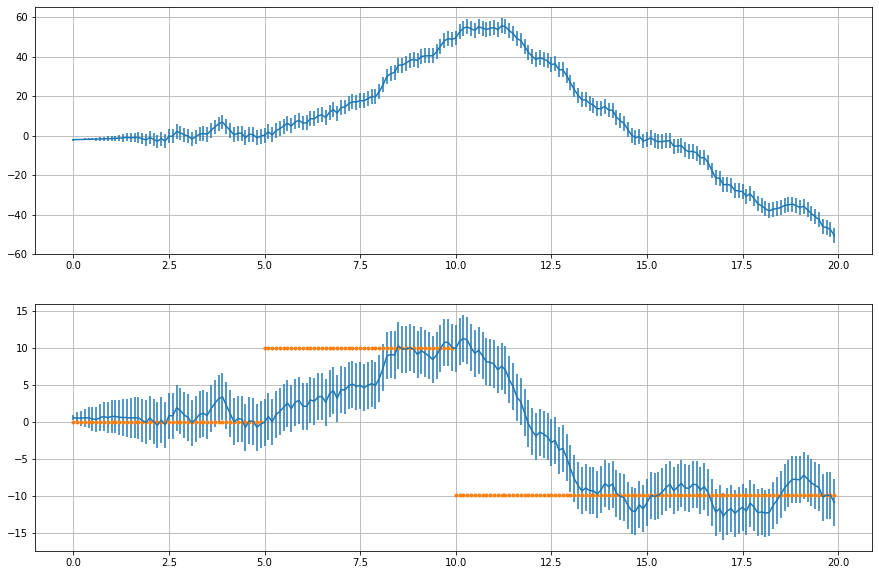

In [544]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.figure(dpi=150)

plt.subplot(211)

plt.errorbar(t, filtered_state_means[:,1], yerr=np.sqrt(filtered_state_covariances[:,1,1]))

plt.grid()


plt.subplot(212)

plt.errorbar(t, filtered_state_means[:,2], yerr=np.sqrt(filtered_state_covariances[:,2,2]))
plt.plot(t, a, ".")

plt.grid()

plt.show()

Die Parameter die verwendet wurden sind unten zu sehen, diese können als Basis verwendet werden einen selbst geschriebenen, optimierten und vereinfachten Kalman Filter zu implementieren.

In [545]:
print( "initial_state_mean:\n", kf.initial_state_mean )
print( "initial_state_covariance:\n", kf.initial_state_covariance )
print()
print( "transition_matrices:\n", kf.transition_matrices )
print( "transition_offsets:\n", kf.transition_offsets )
print( "transition_covariance:\n", kf.transition_covariance )
print()
print( "observation_matrices:\n", kf.observation_matrices )
print( "observation_offsets:\n", kf.observation_offsets )
print( "observation_covariance:\n", kf.observation_covariance )

initial_state_mean:
 [ 1.83965126 -2.05068768  0.5788649 ]
initial_state_covariance:
 [[ 0.12361624 -0.1010729   0.03449036]
 [-0.1010729   0.19715069 -0.10606384]
 [ 0.03449036 -0.10606384  0.10981623]]

transition_matrices:
 [[1.    0.1   0.005]
 [0.    1.    0.1  ]
 [0.    0.    1.   ]]
transition_offsets:
 [0. 0. 0.]
transition_covariance:
 [[ 6.62084006e-02 -9.52778163e-04 -1.46586280e-01]
 [-9.52670961e-04  2.41786939e-02  2.59876296e-04]
 [-1.46586126e-01  2.60512080e-04  4.69520114e-01]]

observation_matrices:
 [[1. 0. 0.]]
observation_offsets:
 [0.]
observation_covariance:
 [[33.87245801]]


## Kalman Filter mit 2 Sensoren (Barometer, IMU) inklusive Sensor Fusion

Um das Beispiel oben zu verbessern verwenden wir nun zusätzlich zum Ort (Höhe) nun auch Messungen der Beschleunigung. Damit machen wir "Sensor Fusion", denn die Messwerte kommen von verschiedenen Sensoren (Höhe von einem Barometer und Beschleunigung von einer IMU).

Wir benötigen nun zusätzlich die sogenannte "observation matrix" die beschreibt wie aus die "observations/observables" (s, a) mit den "states" (s, v, a) zusammenhängen:

$
\left[ {\begin{array}{cc}
  1 & 0 & 0 \\
  0 & 0 & 1 \\
\end{array} } \right]
$

In [546]:
A = np.array([[1, dt, 0.5 * (dt**2)],
              [0, 1,             dt],
              [0, 0,              1]])

kf = KalmanFilter(transition_matrices = A, transition_covariance=0.01*np.eye(3), observation_matrices = [[1, 0, 0], [0, 0, 1]], n_dim_state=3, n_dim_obs=2)
measurements = np.asarray([s_meas, a_meas]).T  # 2 observation(s)
kf = kf.em(measurements)
#kf = kf.em(measurements[0:10])
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
#(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

test2 = filtered_state_means[:,0]

plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.plot(t, filtered_state_means[:,0])
plt.errorbar(t, filtered_state_means[:,0], yerr=np.sqrt(filtered_state_covariances[:,0,0]))
plt.plot(t, s_meas, ".")
plt.grid()
plt.show()

Im direkten Vergleich ist erkennbar, dass der Filter klar weniger Abweichungen zeigt als die Messpunkte aber auch als der vorherige Filter, d.h. wir haben eine Verbesserung erreicht:

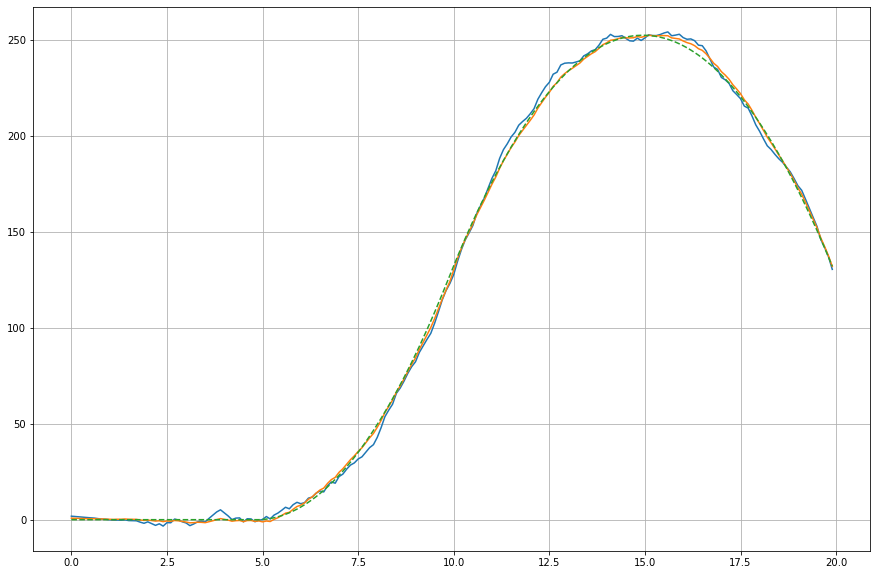

In [547]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
plt.plot(t, test1)
plt.plot(t, test2)
plt.plot(t, s, "--")
plt.grid()

In [555]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
plt.bar(t, (test1 - s))
plt.bar(t, (test2 - s))
plt.grid()

Es zeigt sich, dass die Sensor Fusion klar zu einer Verbesserung geführt hat:
- die Genauigkeit (Richtigkeit und Präzission) haben zugenommen
- die Robustheit;
  - hier nicht explizit gezeigt, es sind für die Ermittlung der Filter-Parameter (EM Algorithmus) weniger Punkte der Messreihe nötig - probieren Sie es anhand der Daten aus, z.B. mit 10 Messpunkten
  - wird die Betarchtung mit anderen Zufallsdaten (Noise) wiederholt, ändern sin die Filter-Parameter nur geringfügig - probieren Sie es anhand der Daten aus

Wie zuvor erhalten wir gratis die Geschwindigkeit dazu:

In [557]:
plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.figure(dpi=150)

plt.subplot(211)

plt.errorbar(t, filtered_state_means[:,1], yerr=np.sqrt(filtered_state_covariances[:,1,1]))

plt.grid()


plt.subplot(212)

plt.errorbar(t, filtered_state_means[:,2], yerr=np.sqrt(filtered_state_covariances[:,2,2]))
plt.plot(t, a, ".")

plt.grid()

plt.show()

In [556]:
print( "initial_state_mean:\n", kf.initial_state_mean )
print( "initial_state_covariance:\n", kf.initial_state_covariance )
print()
print( "transition_matrices:\n", kf.transition_matrices )
print( "transition_offsets:\n", kf.transition_offsets )
print( "transition_covariance:\n", kf.transition_covariance )
print()
print( "observation_matrices:\n", kf.observation_matrices )
print( "observation_offsets:\n", kf.observation_offsets )
print( "observation_covariance:\n", kf.observation_covariance )

initial_state_mean:
 [ 0.79414926 -0.75116588  0.37486779]
initial_state_covariance:
 [[ 0.0946354  -0.04460833  0.00349814]
 [-0.04460833  0.06161401 -0.01824962]
 [ 0.00349814 -0.01824962  0.04267291]]

transition_matrices:
 [[1.    0.1   0.005]
 [0.    1.    0.1  ]
 [0.    0.    1.   ]]
transition_offsets:
 [0. 0. 0.]
transition_covariance:
 [[ 0.03800587 -0.002215   -0.17331039]
 [-0.002215    0.01368842  0.01492777]
 [-0.17331039  0.01492777  1.48073441]]

observation_matrices:
 [[1 0 0]
 [0 0 1]]
observation_offsets:
 [0. 0.]
observation_covariance:
 [[33.91340276  0.41193571]
 [ 0.41193571  1.14486663]]


Nun können wir die Parameter verwenden um einen herkömmlichen Kalman Filter ohne weitere (blackbox) Optimierungen zu erstellen und mit diesem zu arbeiten, das Ergebnis ist aus offensichlichen Gründen das Selbe da der Filter durch die Parameter vollständig bestimmt ist:

In [559]:
kf = KalmanFilter(
initial_state_mean = np.array(
 [ 0.79414926, -0.75116588,  0.37486779]),
initial_state_covariance = np.array(
 [[ 0.0946354,  -0.04460833,  0.00349814],
 [-0.04460833,  0.06161401, -0.01824962],
 [ 0.00349814, -0.01824962,  0.04267291]]),

transition_matrices = np.array(
 [[1.,    0.1,   0.005],
 [0.,    1.,    0.1  ],
 [0.,    0.,    1.   ]]),
transition_offsets = np.array(
 [0., 0., 0.]),
transition_covariance = np.array(
 [[ 0.03800587, -0.002215,   -0.17331039],
 [-0.002215,    0.01368842,  0.01492777],
 [-0.17331039,  0.01492777,  1.48073441]]),

observation_matrices = np.array(
 [[1, 0, 0],
 [0, 0, 1]]),
observation_offsets = np.array(
 [0., 0.]),
observation_covariance = np.array(
 [[33.91340276,  0.41193571],
 [ 0.41193571,  1.14486663]]),)
measurements = np.asarray([s_meas, a_meas]).T  # 2 observation(s)
kf = kf.em(None, n_iter=0)  # DISABLED (do not modify given parameters!)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
#(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

plt.figure(figsize=2.5*np.array(plt.rcParams["figure.figsize"]))
#plt.plot(t, filtered_state_means[:,0])
plt.errorbar(t, filtered_state_means[:,0], yerr=np.sqrt(filtered_state_covariances[:,0,0]))
plt.plot(t, s_meas, ".")
plt.grid()
plt.show()

Wir können nun diesen Filter (die Parameter) verwenden um eine eigene Implementation mit Vereinfachungen und Optimierungen für die performante Berechnung auf einem embedded System zu erstellen.

In [569]:
# ( ev. auch nützlich: https://towardsdatascience.com/kalman-filter-in-a-nutshell-e66154a06862 )